In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from datetime import datetime
import warnings
from sklearn.impute import SimpleImputer
import os
import pickle

In [2]:
warnings.filterwarnings('ignore')


plt.style.use('ggplot')
sns.set(style="whitegrid")


def load_data(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file '{file_path}' does not exist. Please provide a valid file path.")
    
    # CSV file ko read kar
    df = pd.read_csv(file_path)
    
    print(f"Loaded data with {df.shape[0]} rows and {df.shape[1]} columns")
    print(f"Columns: {df.columns.tolist()}")
    
    
    missing_values = df.isnull().sum()
    print("\nMissing values per column:")
    print(missing_values[missing_values > 0])
    
    return df

In [3]:
def feature_engineering(df):
    
    df_processed = df.copy()
    
    print("Original columns:", df_processed.columns.tolist())
    
    
    date_time_columns = ['Data', 'Time']
    if all(col in df_processed.columns for col in date_time_columns):
        try:
            df_processed['DateTime'] = pd.to_datetime(df_processed['Data'] + ' ' + df_processed['Time'], 
                                            format='%m/%d/%Y %I:%M:%S %p', 
                                            errors='coerce')
        except Exception as e:
            print(f"Warning: Error in datetime conversion: {e}")
            print("Attempting alternative datetime format...")
            try:
                df_processed['DateTime'] = pd.to_datetime(df_processed['Data'] + ' ' + df_processed['Time'], errors='coerce')
            except:
                print("Could not convert to datetime. Creating placeholder DateTime column.")
                df_processed['DateTime'] = pd.to_datetime('2020-01-01')
        
       
        if 'DateTime' in df_processed.columns:
            df_processed['Hour'] = df_processed['DateTime'].dt.hour
            df_processed['Minute'] = df_processed['DateTime'].dt.minute
            df_processed['DayOfYear'] = df_processed['DateTime'].dt.dayofyear
            df_processed['Month'] = df_processed['DateTime'].dt.month
    
    
    if 'TimeSunRise' in df_processed.columns and 'TimeSunSet' in df_processed.columns:
        
        def time_to_minutes(time_str):
            try:
                hours, minutes = map(int, time_str.split(':'))
                return hours * 60 + minutes
            except:
                return np.nan
        
        df_processed['SunriseMinutes'] = df_processed['TimeSunRise'].apply(time_to_minutes)
        df_processed['SunsetMinutes'] = df_processed['TimeSunSet'].apply(time_to_minutes)
        
        
        df_processed['DaylightMinutes'] = df_processed['SunsetMinutes'] - df_processed['SunriseMinutes']
        
        
        if 'Hour' in df_processed.columns and 'Minute' in df_processed.columns:
            df_processed['CurrentTimeMinutes'] = df_processed['Hour'] * 60 + df_processed['Minute']
            df_processed['MinutesSinceSunrise'] = df_processed['CurrentTimeMinutes'] - df_processed['SunriseMinutes']
            df_processed['MinutesToSunset'] = df_processed['SunsetMinutes'] - df_processed['CurrentTimeMinutes']
            
            
            df_processed['IsDay'] = ((df_processed['CurrentTimeMinutes'] >= df_processed['SunriseMinutes']) & 
                           (df_processed['CurrentTimeMinutes'] <= df_processed['SunsetMinutes'])).astype(int)
    
    
    if 'Temperature' in df_processed.columns and 'Humidity' in df_processed.columns:
        df_processed['Temp_Humidity'] = df_processed['Temperature'] * df_processed['Humidity']
    
    if 'Pressure' in df_processed.columns and 'Humidity' in df_processed.columns:
        df_processed['Pressure_Humidity'] = df_processed['Pressure'] * df_processed['Humidity']
    
    
    columns_to_drop = ['UNIXTime', 'Data', 'Time', 'DateTime', 'TimeSunRise', 'TimeSunSet']
    columns_to_drop = [col for col in columns_to_drop if col in df_processed.columns]
    if columns_to_drop:
        df_processed = df_processed.drop(columns=columns_to_drop)
    
    print(f"After feature engineering, DataFrame shape: {df_processed.shape}")
    print(f"Final columns: {df_processed.columns.tolist()}")
    
    return df_processed



In [4]:
def prepare_data(df):
   
    print("\nChecking for missing values before model preparation...")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])
    
    
    if 'Radiation' in df.columns:
        target_col = 'Radiation'
    else:
        print("Warning: 'Radiation' column not found. Using the last column as target.")
        target_col = df.columns[-1]
    
    
    df_clean = df.dropna(subset=[target_col])
    print(f"Dropped {len(df) - len(df_clean)} rows with missing target values")
    
    X = df_clean.drop(target_col, axis=1)
    y = df_clean[target_col]
    
    
    print(f"X shape before split: {X.shape}")
    print(f"X columns: {X.columns.tolist()}")
    
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    

    non_all_missing_cols = X_train.columns[~X_train.isna().all()].tolist()
    print(f"Columns with some non-missing values: {non_all_missing_cols}")
    
    if len(non_all_missing_cols) == 0:
        raise ValueError("All columns have all missing values. Cannot proceed with model training.")
    
    
    X_train_filtered = X_train[non_all_missing_cols]
    X_test_filtered = X_test[non_all_missing_cols]
    
    
    imputer = SimpleImputer(strategy='mean')
    
    
    X_train_array = imputer.fit_transform(X_train_filtered)
    X_test_array = imputer.transform(X_test_filtered)
    
   
    X_train_imputed = pd.DataFrame(
        X_train_array,
        columns=non_all_missing_cols,  
        index=X_train.index
    )
    
    X_test_imputed = pd.DataFrame(
        X_test_array,
        columns=non_all_missing_cols,  
        index=X_test.index
    )
    
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)
    
    print(f"Data prepared: X_train shape: {X_train_scaled.shape}, X_test shape: {X_test_scaled.shape}")
    
    return X_train_imputed, X_test_imputed, X_train_scaled, X_test_scaled, y_train, y_test, scaler, imputer

In [5]:
def build_models(X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test):
    models = {}
    predictions = {}
    
   
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train)
    models['Linear Regression'] = lr
    predictions['Linear Regression'] = lr.predict(X_test_scaled)
    
    
    lasso = Lasso(alpha=0.01, max_iter=10000, random_state=42)
    lasso.fit(X_train_scaled, y_train)
    models['Lasso'] = lasso
    predictions['Lasso'] = lasso.predict(X_test_scaled)
    
    
    ridge = Ridge(alpha=1.0, random_state=42)
    ridge.fit(X_train_scaled, y_train)
    models['Ridge'] = ridge
    predictions['Ridge'] = ridge.predict(X_test_scaled)
    
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    models['Random Forest'] = rf
    predictions['Random Forest'] = rf.predict(X_test)
    
    
    predictions['Hybrid'] = (
        0.2 * predictions['Linear Regression'] + 
        0.2 * predictions['Lasso'] +
        0.2 * predictions['Ridge'] +
        0.4 * predictions['Random Forest']
    )
    
    return models, predictions


In [6]:
def evaluate_models(y_test, predictions):
    results = {}
    
    for model_name, y_pred in predictions.items():
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results[model_name] = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        }
        
        print(f"\n{model_name} Performance:")
        print(f"MSE: {mse:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"R2 Score: {r2:.4f}")
    
    return results


In [7]:
def create_visualizations(df, X_test, y_test, predictions, models):
    plt.figure(figsize=(12, 10))
    correlation = df.corr()
    mask = np.triu(correlation)
    sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', mask=mask)
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.show()
    
    
    plt.figure(figsize=(15, 10))
    for i, (model_name, y_pred) in enumerate(predictions.items(), 1):
        if i <= 4:  # Only plot the first 4 models to fit in a 2x2 grid
            plt.subplot(2, 2, i)
            plt.scatter(y_test, y_pred, alpha=0.5)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
            plt.xlabel('Actual Radiation')
            plt.ylabel('Predicted Radiation')
            plt.title(f'{model_name}: Actual vs Predicted')
    plt.tight_layout()
    plt.show()
   
    if 'Random Forest' in models:
        plt.figure(figsize=(12, 8))
        feature_importance = pd.DataFrame({
            'Feature': X_test.columns,
            'Importance': models['Random Forest'].feature_importances_
        }).sort_values('Importance', ascending=False)
        
        sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
        plt.title('Random Forest: Top 10 Feature Importance')
        plt.tight_layout()
        plt.show()
    
    
    if 'Lasso' in models and 'Ridge' in models:
        plt.figure(figsize=(14, 10))
        
        
        lasso_coef = pd.DataFrame({
            'Feature': X_test.columns,
            'Coefficient': models['Lasso'].coef_
        }).sort_values('Coefficient', key=abs, ascending=False)
        
        plt.subplot(2, 1, 1)
        sns.barplot(x='Coefficient', y='Feature', data=lasso_coef.head(10))
        plt.title('Lasso: Top 10 Feature Coefficients')
        
        
        ridge_coef = pd.DataFrame({
            'Feature': X_test.columns,
            'Coefficient': models['Ridge'].coef_
        }).sort_values('Coefficient', key=abs, ascending=False)
        
        plt.subplot(2, 1, 2)
        sns.barplot(x='Coefficient', y='Feature', data=ridge_coef.head(10))
        plt.title('Ridge: Top 10 Feature Coefficients')
        
        plt.tight_layout()
        plt.show()
    
   
    plt.figure(figsize=(12, 6))
    model_names = list(predictions.keys())
    r2_scores = [r2_score(y_test, predictions[model]) for model in model_names]
    rmse_scores = [np.sqrt(mean_squared_error(y_test, predictions[model])) for model in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, r2_scores, width, label='R² Score')
    ax.bar(x + width/2, rmse_scores, width, label='RMSE')
    
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend()
    plt.title('Model Comparison: R² Score and RMSE')
    plt.tight_layout()
    plt.show()
    
   
    plt.figure(figsize=(15, 10))
    for i, (model_name, y_pred) in enumerate(predictions.items(), 1):
        if i <= 4:  # Only plot the first 4 models
            plt.subplot(2, 2, i)
            residuals = y_test - y_pred
            plt.scatter(y_pred, residuals, alpha=0.5)
            plt.axhline(y=0, color='r', linestyle='--')
            plt.xlabel('Predicted Radiation')
            plt.ylabel('Residuals')
            plt.title(f'{model_name}: Residual Plot')
    plt.tight_layout()
    plt.show()
    
    
    if len(y_test) > 1:
        plt.figure(figsize=(15, 6))
        plt.plot(y_test.values, label='Actual', marker='o', linestyle='-', alpha=0.7)
        plt.plot(predictions['Hybrid'], label='Hybrid Model Prediction', marker='x', linestyle='--')
        plt.title('Time Series: Actual vs Hybrid Model Prediction')
        plt.xlabel('Sample Index')
        plt.ylabel('Radiation')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()



Loaded data with 32686 rows and 11 columns
Columns: ['UNIXTime', 'Data', 'Time', 'Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeSunRise', 'TimeSunSet']

Missing values per column:
UNIXTime                  31187
Data                      31187
Time                      31187
Radiation                 31187
Temperature               31187
Pressure                  31187
Humidity                  31187
WindDirection(Degrees)    31187
Speed                     31187
TimeSunRise               31187
TimeSunSet                31187
dtype: int64
Original columns: ['UNIXTime', 'Data', 'Time', 'Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeSunRise', 'TimeSunSet']
After feature engineering, DataFrame shape: (32686, 19)
Final columns: ['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'Hour', 'Minute', 'DayOfYear', 'Month', 'SunriseMinutes', 'SunsetMinutes', 'DaylightMinu

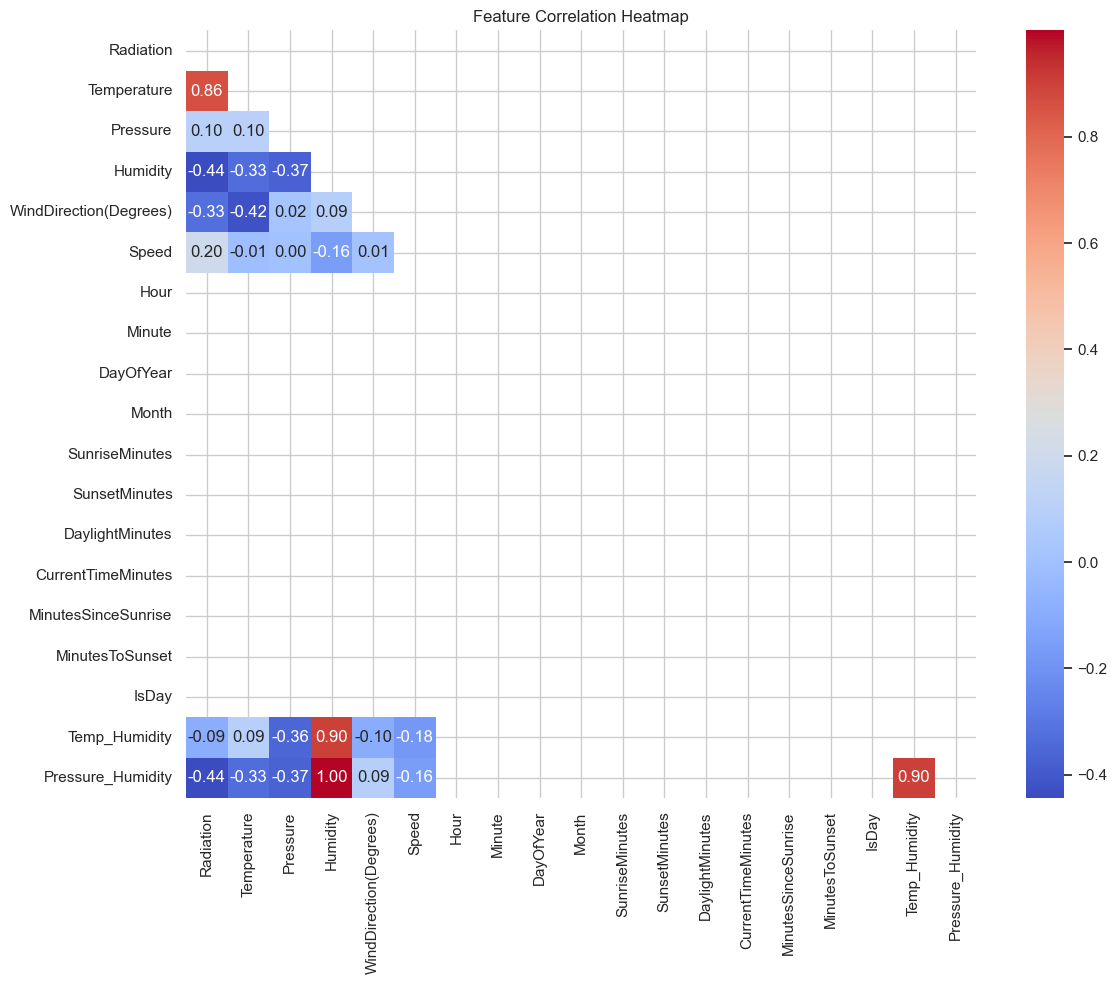

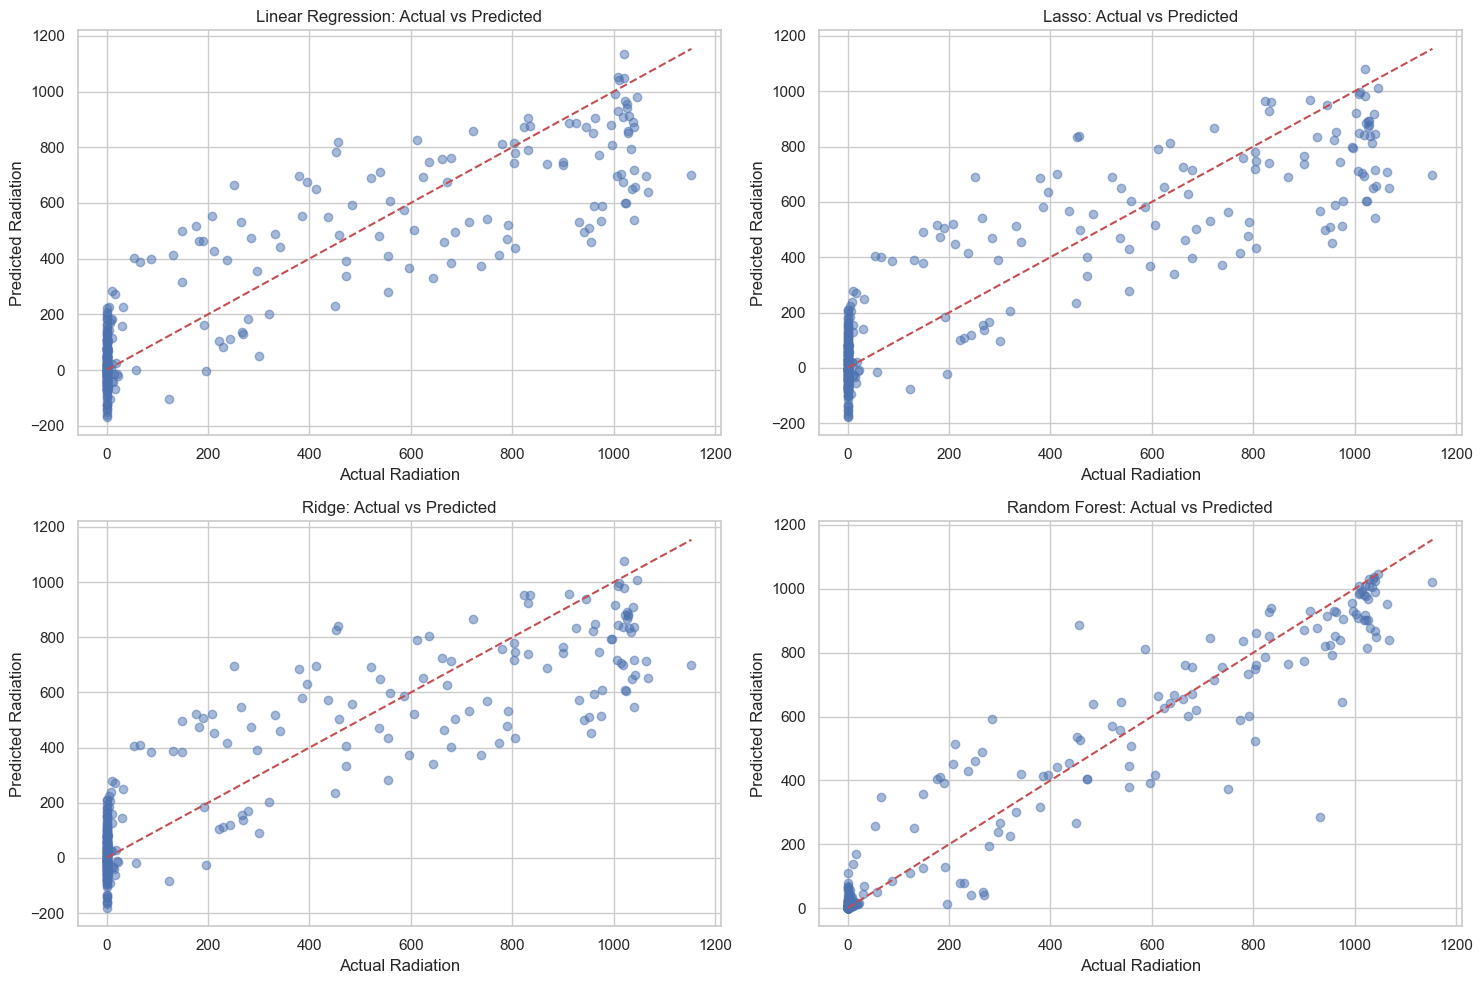

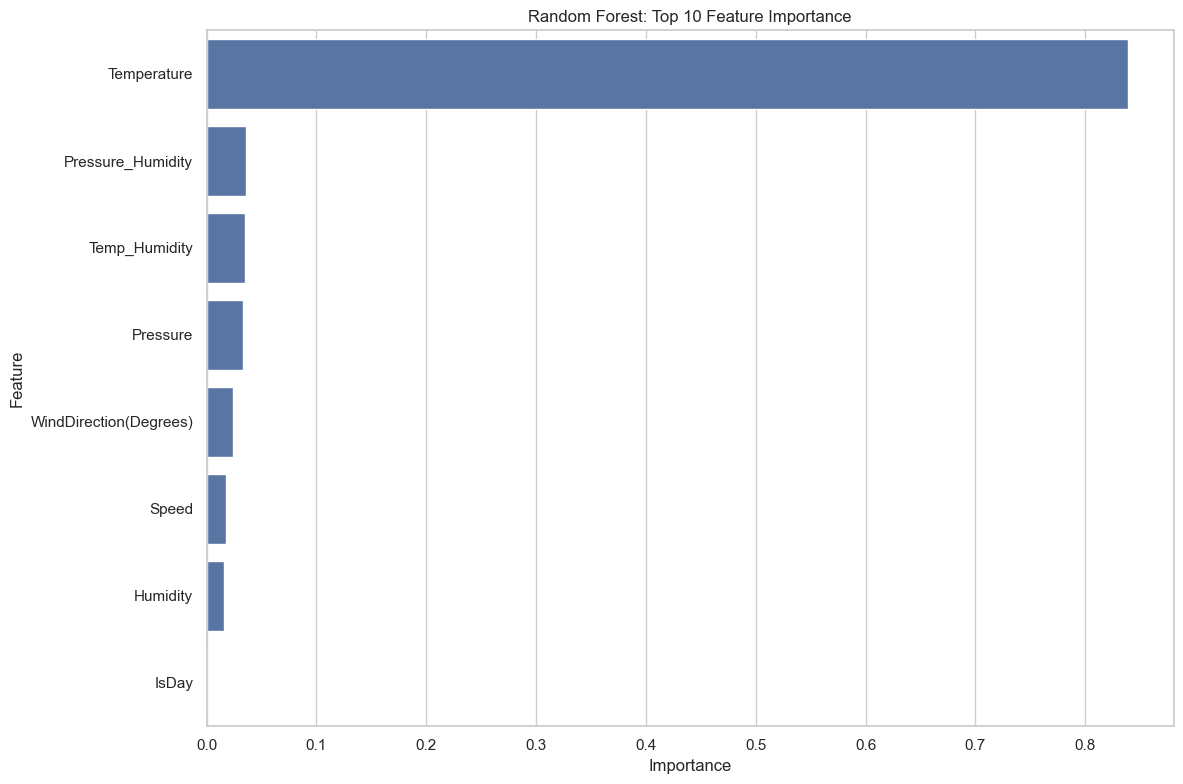

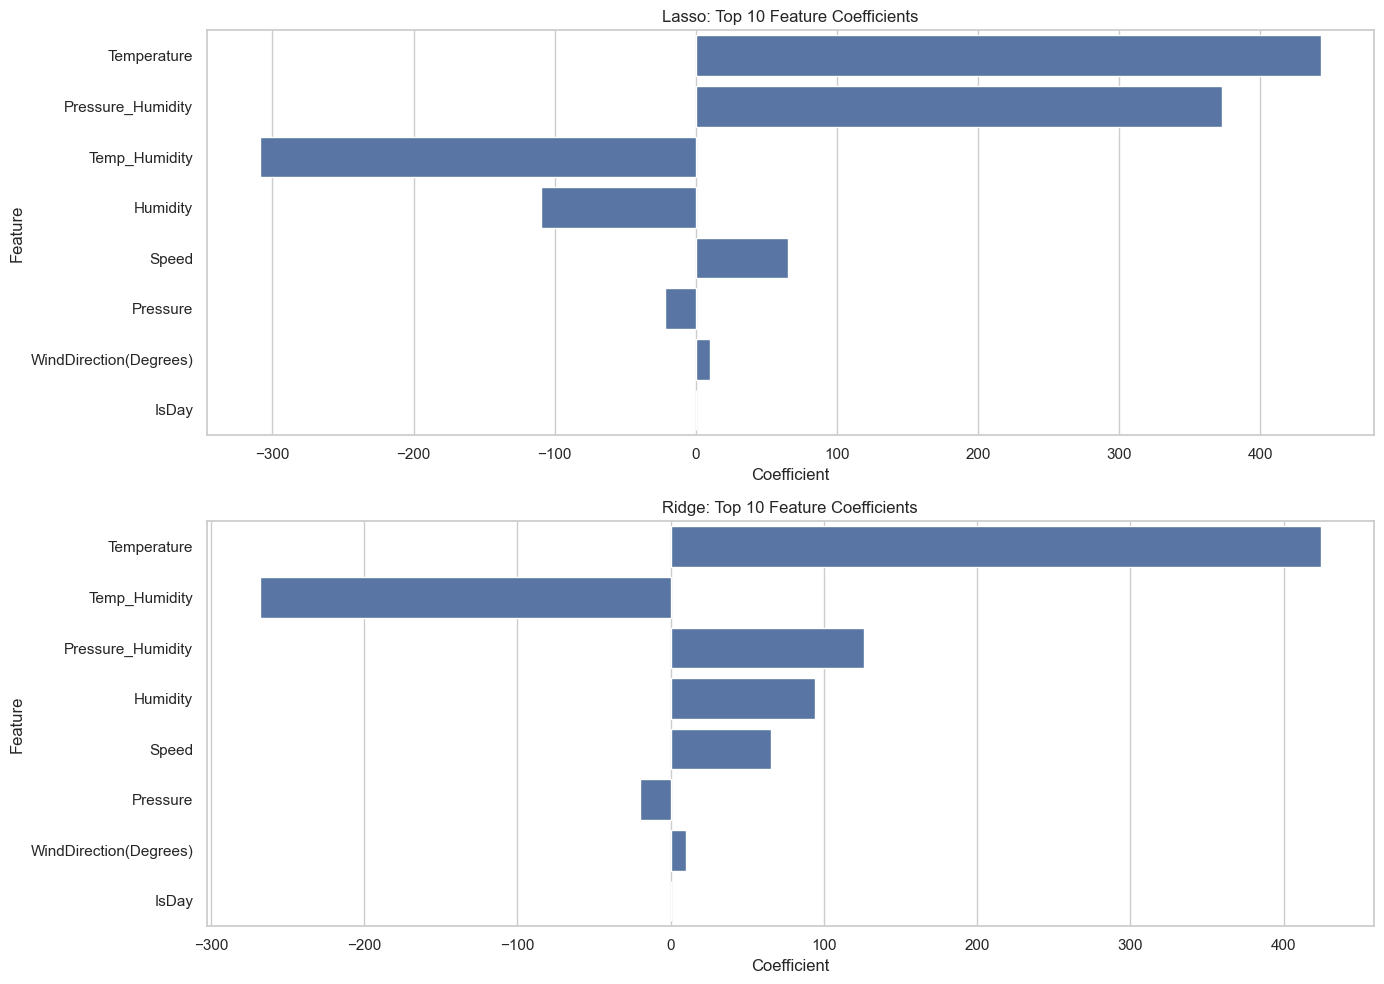

<Figure size 1200x600 with 0 Axes>

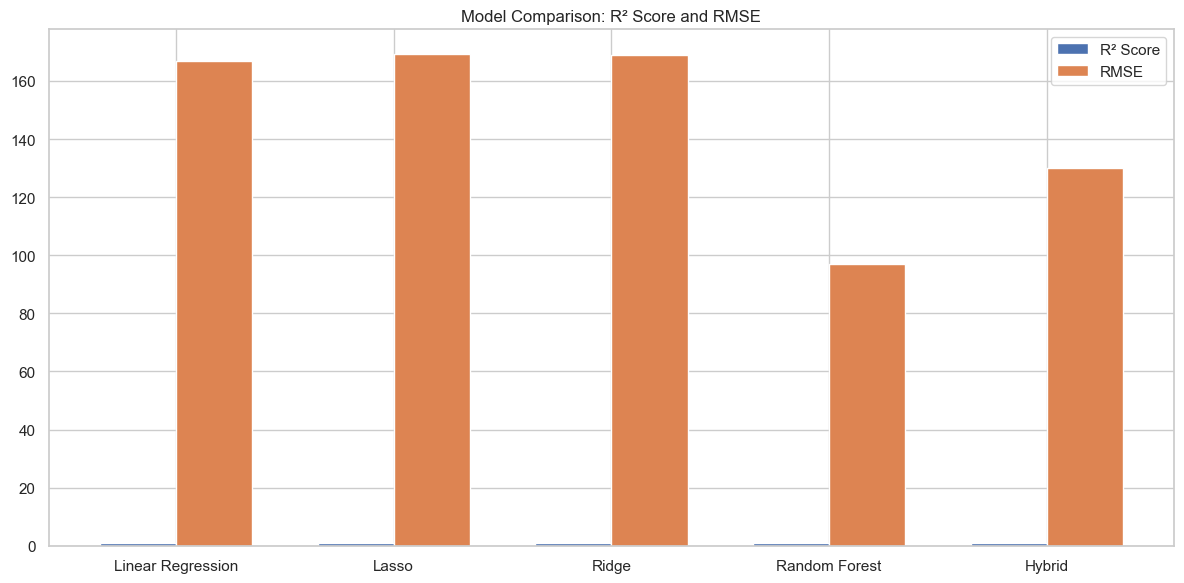

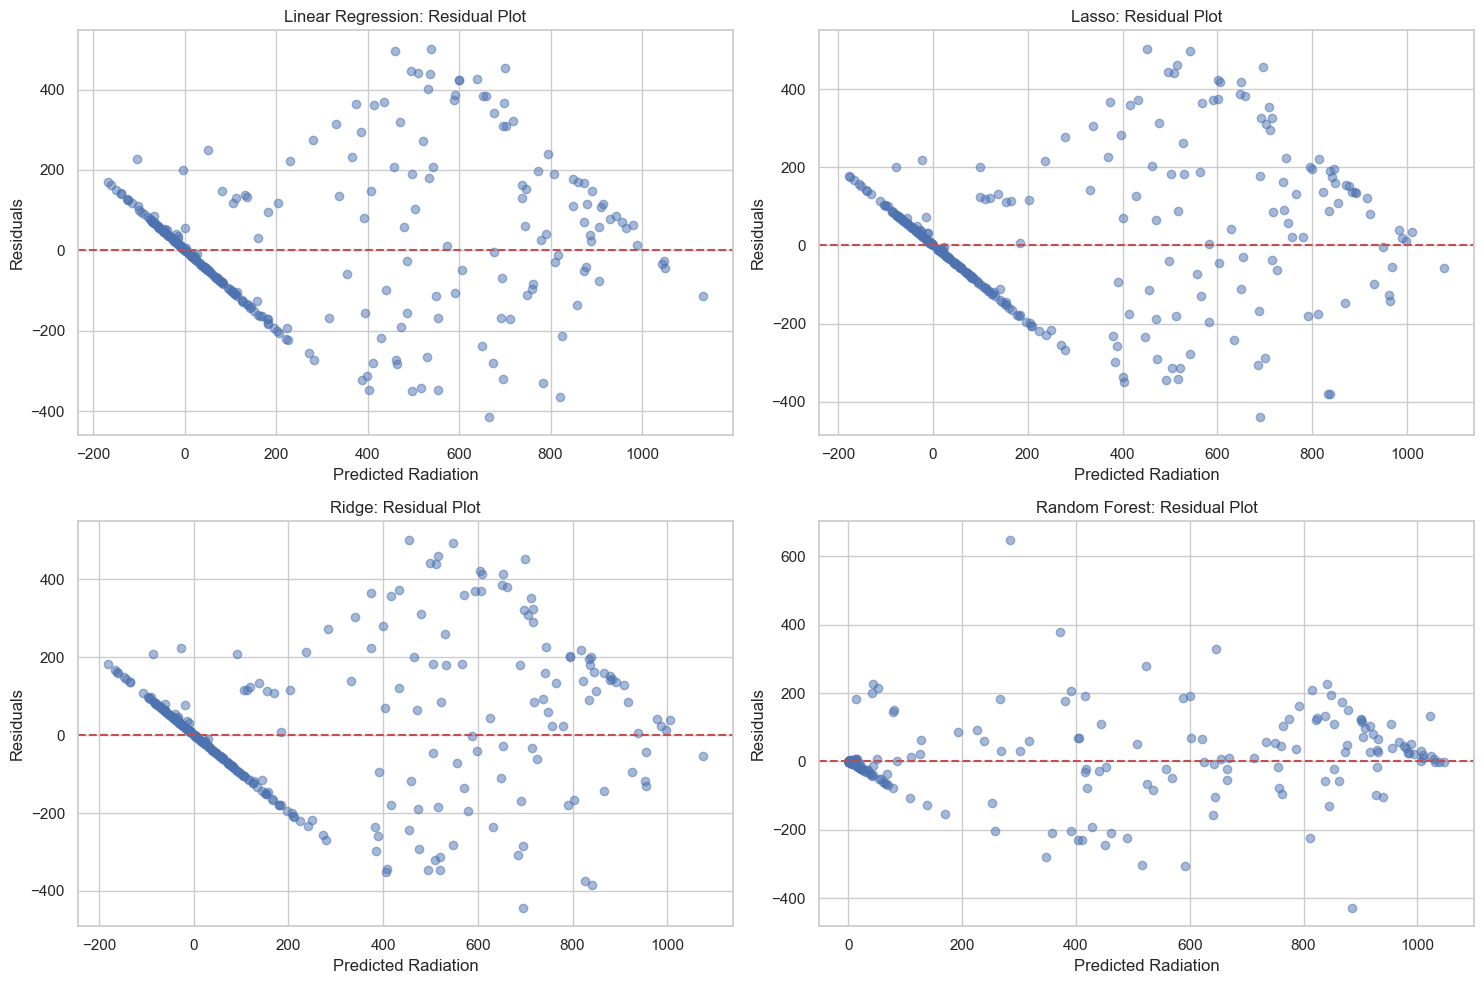

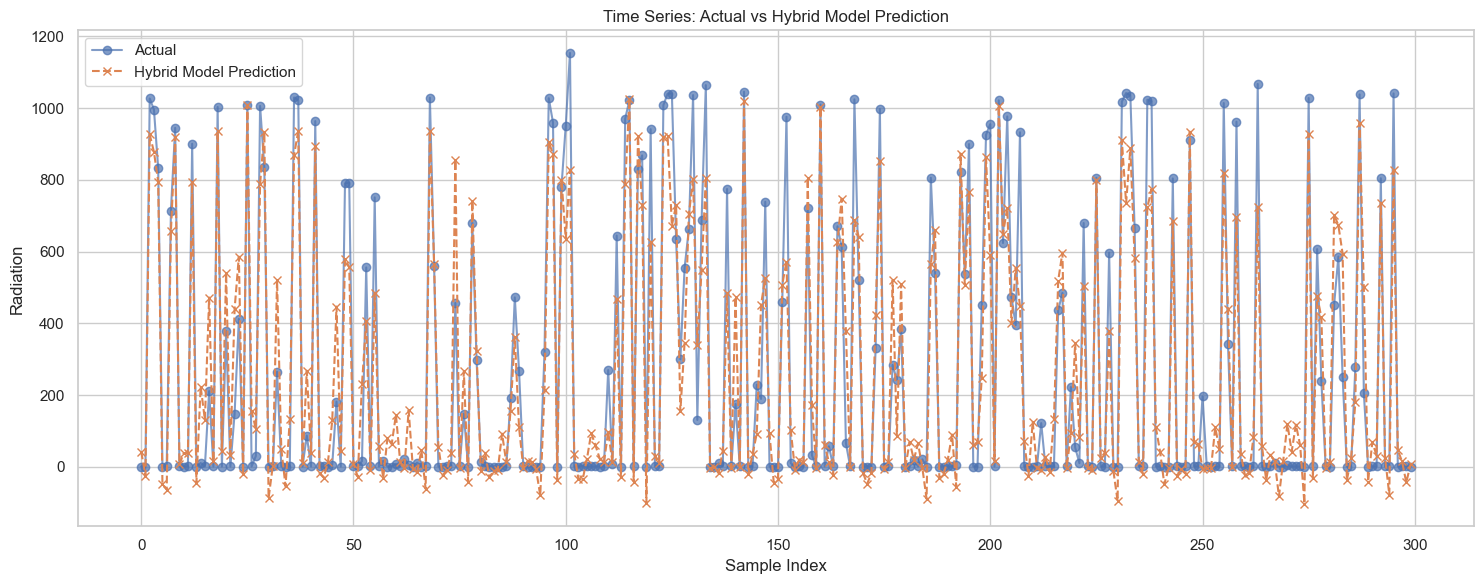


Best model (Random Forest) saved as 'best_radiation_model.pkl'
Hybrid model weights saved as 'hybrid_model_weights.pkl'
Imputer and scaler saved as 'imputer.pkl' and 'scaler.pkl'

Best model based on R2 score: Random Forest


In [9]:

def save_best_model(models, results, imputer, scaler):
    
    best_model_name = max(results.items(), key=lambda x: x[1]['R2'])[0]
    best_model = models.get(best_model_name)
    
    if best_model:
        
        with open('best_radiation_model.pkl', 'wb') as f:
            pickle.dump(best_model, f)
        print(f"\nBest model ({best_model_name}) saved as 'best_radiation_model.pkl'")
    
    
    with open('imputer.pkl', 'wb') as f:
        pickle.dump(imputer, f)
    
    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    
    
    hybrid_weights = {
        'Linear Regression': 0.2,
        'Lasso': 0.2,
        'Ridge': 0.2,
        'Random Forest': 0.4
    }
    
    with open('hybrid_model_weights.pkl', 'wb') as f:
        pickle.dump(hybrid_weights, f)
    print("Hybrid model weights saved as 'hybrid_model_weights.pkl'")
    print("Imputer and scaler saved as 'imputer.pkl' and 'scaler.pkl'")


file_path = 'SolarPrediction.csv'  

try:
    
    df = load_data(file_path)
    
   
    df_processed = feature_engineering(df)
    
    
    X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test, scaler, imputer = prepare_data(df_processed)
    
    
    models, predictions = build_models(X_train, X_test, X_train_scaled, X_test_scaled, y_train, y_test)
    
    
    results = evaluate_models(y_test, predictions)
    
    
    create_visualizations(df_processed, X_test, y_test, predictions, models)
    
    
    save_best_model(models, results, imputer, scaler)
    
   
    best_model = max(results.items(), key=lambda x: x[1]['R2'])[0]
    print(f"\nBest model based on R2 score: {best_model}")
    
except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()